In [1]:
##All General Import Statements
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os
print(os.listdir("../input"))

['creditcard.csv']


# Anomaly Detection Algorithms: Isolation Forest vs the Rest

<p>This notebook shows a simplified implementation of the algorithm Isolation Forest and compares its Scikit-learn implementation with other popular anomaly detection algorithms. (KMeans, Local Outlier Factor, One-Class SVM)</p>

## Isolation Forests in Python

The Algorithm has 3 parts:
    1. Forest
    2. Isolation Tree
    3. Evaluation (Path Length)

### Common Classes

The below code defines classes for external and internal nodes

In [2]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

### Forest

In [3]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=df_data.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

### Isolation Tree

In [4]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

### Path Length

In [5]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

## Test Run

Let us now test the algorithm on a test dataset.
Source: https://www.kaggle.com/dalpozz/creditcardfraud

In [6]:
df=pd.read_csv("../input/creditcard.csv")
y_true=df['Class']
df_data=df.drop('Class',1)

Next, we create the forest.

In [7]:
sampleSize=10000
ifor = iForest(df_data.sample(100000),10,sampleSize) ##Forest of 10 trees

Next, we select 1000 random datapoints and get their path lengths. The purpose for this is to plot and see if anomalies actually have shorter path lengths.

In [8]:
posLenLst=[]
negLenLst=[]

for sim in range(1000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))
        
    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

Finally, we plot the path lengths.

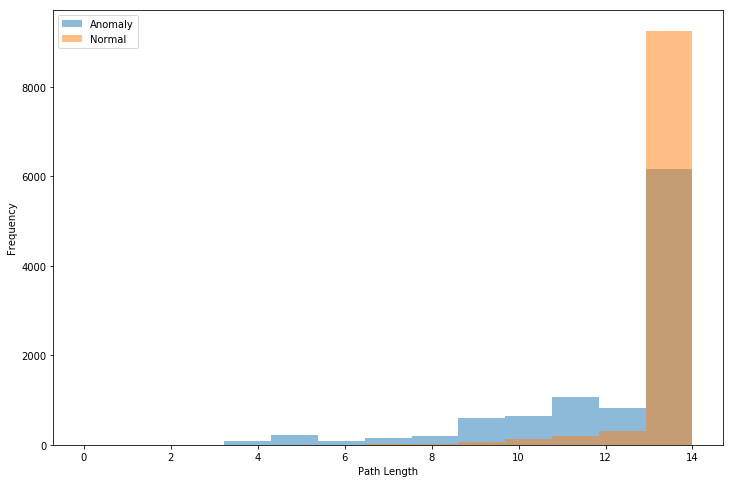

In [9]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

Anomalies do seem to have a lower path length. Not bad for random division!

#### Notes:

The above implementation ignores three aspects of the actual algorithm fo the sake of simplicity.
1. The average depth needs to be added to the depth once the current length hits the height limit
2. The path lengths are not normalized between trees and hence the actual values are used for plotting
3. The authors of the paper suggest using kurtosis to select features as a refinement over random selection

## Plotting the Data

Using a technique called T-SNE, we can reduce the dimensions of the data and create a 2D plot. The objective here is to show that distance based anomaly detection methods might not work as well as other techniques on this dataset. This is because the positive cases are not too far away from the normal cases.

In [10]:
df_plt = df[df['Class']==0].sample(1000)
df_plt_pos = df[df['Class']==1].sample(20)
df_plt = pd.concat([df_plt,df_plt_pos])
y_plt = df_plt['Class']
X_plt = df_plt.drop('Class',1)

In [11]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

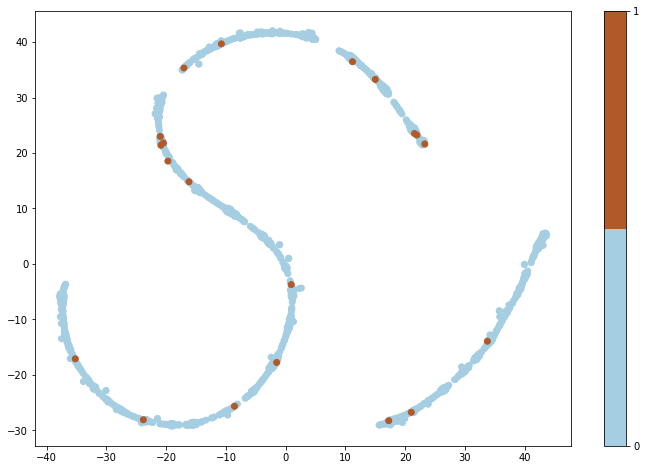

In [12]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

## Time for the Real Fight!

To keep things even, all of the algorithms are run with their default parameters.

Let's start by importing the scikit-learn implementations of all 4 algorithms.

Next, let's create a train and test dataset.

In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Finally, let's create a few helper functions that help with training and testing the models. The preprocess function is not used in this notebook but it might help improve the scores on the KMeans and One Class SVM models.

In [14]:
## Not required for Isolation Forest
def preprocess(df_data):
    for col in df_data:
        df_data[col] = (df_data[col] - np.min(df_data[col]))/(np.max(df_data[col]) - np.min(df_data[col]))
    return

<b>Note:</b> The below train and predict functions are designed to output ensemble models (bagged models), with the default size being 5 models. The Isolation Forest and One Class SVM use these functions.

In [15]:
## Not valid for LOF
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X= df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    return mdlLst

## Not valif for LOF
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

#### Isolation Forest

In [16]:
ifModel = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

<b>Note:</b> The magic function timeit does not let us use any variable that is created in the timeit cell. Hence, ecery cell with a timeit magic function will have a corresponding regular cell with the same code.

In [17]:
if_mdlLst = train(X_train, ifModel)

In [18]:
if_y_pred = predict(X_test, if_mdlLst)
if_y_pred = 1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [19]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [20]:
from sklearn.metrics import classification_report, average_precision_score, f1_score, recall_score, precision_score
def print_classification_report(y_test, y_predic):
    print('Classification report:')
    print(classification_report(y_test, y_predic))

    print('Average Precision = ' + str(average_precision_score(y_test, y_predic)))

    print('\nBinary F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "binary")
    Recall = recall_score(y_test, y_predic, average = "binary")
    Precision = precision_score(y_test, y_predic, average = "binary")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

    print('\nMicro F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "micro")
    Recall = recall_score(y_test, y_predic, average = "micro")
    Precision = precision_score(y_test, y_predic, average = "micro")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

    print('\nMacro F1 Score, Recall and Precision:')
    f = f1_score(y_test, y_predic, average = "macro")
    Recall = recall_score(y_test, y_predic, average = "macro")
    Precision = precision_score(y_test, y_predic, average = "macro")
    print('F1 Score %f' %f)
    print('Recall Score %f' %Recall)
    print('Precision Score %f' %Precision)

In [21]:
print_classification_report(y_test, if_y_pred_class)

Classification report:
             precision    recall  f1-score   support

          0       1.00      0.95      0.97     85307
          1       0.03      0.88      0.05       136

avg / total       1.00      0.95      0.97     85443

Average Precision = 0.024966653899278626

Binary F1 Score, Recall and Precision:
F1 Score 0.054434
Recall Score 0.882353
Precision Score 0.028083

Micro F1 Score, Recall and Precision:
F1 Score 0.951207
Recall Score 0.951207
Precision Score 0.951207

Macro F1 Score, Recall and Precision:
F1 Score 0.514696
Recall Score 0.916835
Precision Score 0.513943


#### KMeans

The top 5% of the farthest point from cluster centers are itentified as fraud (outliers)

In [23]:
kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

In [24]:
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.as_matrix(),X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

#### LOF

Local Outlier Factor only looks at the local neighbourhood of a data point and hence cannot make predictions on out of sample data points. Hence we work directly with X_test here.

In [28]:
clf=LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=-1)

In [29]:
clf.fit(X_test)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=-1,
          n_neighbors=20, p=2)

In [30]:
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

In [31]:
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

#### One-Class SVM*

##### *Any kernel except linear will take a while. Feel free to grab a coffee, if you decide to change the kernel type

In [35]:
alg=OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=200, verbose=False, max_iter=-1, random_state=42)

In [36]:
osvm_mdlLst=train(X_train,alg)

In [37]:
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

In [38]:
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

In [39]:
print_classification_report(y_test, osvm_y_pred_class)

Classification report:
             precision    recall  f1-score   support

          0       1.00      0.50      0.66     85307
          1       0.00      0.54      0.00       136

avg / total       1.00      0.50      0.66     85443

Average Precision = 0.0016614961171177208

Binary F1 Score, Recall and Precision:
F1 Score 0.003429
Recall Score 0.544118
Precision Score 0.001720

Micro F1 Score, Recall and Precision:
F1 Score 0.496600
Recall Score 0.496600
Precision Score 0.496600

Macro F1 Score, Recall and Precision:
F1 Score 0.333338
Recall Score 0.520321
Precision Score 0.500129


## Conclusion

Isolation forest has the 2nd fastest training time. This is very impressive considering that our model is actually an ensemble of 5 Isolation forest models.

The algorithm doesn't fare so well but this might be due to the over head of the ensemble structure.

Coming to model performance, our isolation forest ensemble model is a clear winner!